# Manual clustering with phy

This notebook example gives an overview of the Python API for manual clustering provided by the [phy](https://github.com/kwikteam/phy) library.

## Loading a dataset

Let's import the library:

In [1]:
import phy
from phy.cluster.manual.session import Session

We'll also need a few standard scientific Python libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%gui qt

This is the full path to a Kwik file:

In [3]:
filename = "/home/cyrille/1_simple120sec/test_hybrid_120sec.kwik"

The `Session` is the main gateway to your clustering session. It gives you access to the data, the clustering process, and the views.

In [4]:
session = Session()

This is the command to open the dataset:

In [5]:
session.open(filename)

The very first call may last a few minutes, because an internal cache is created in the same folder as your data. This will make the program much faster. Once the cache exists, re-loading the data is very fast.

## What's in the data?

You can use tab completion in IPython to inspect the properties provided by the `Session` object. Type `session.<TAB>`:

    session.

The `Session` object provides several useful methods, as we'll see later. It also gives access to two other important objects:

* `session.model` stores the experiment's data
* `session.clustering` is responsible for the manual clustering process

For now, let's have a look at the model.

In [6]:
model = session.model

Here are a few details about the experiment:

> Note: [support for multiple shanks is still WIP](https://github.com/kwikteam/phy/issues/142). Currently, phy loads the first shank automatically.

In [7]:
model.n_spikes

18539

In [8]:
model.n_channels

32

The `metadata` is a dictionary with various parameters used for automatic clustering (as used in SpikeDetekt2 and KlustaKwik).

In [9]:
model.metadata

{'__doc__': b'Contain default parameters.',
 'assigntofirstclosestmask': 1,
 'chunk_overlap': 300,
 'chunk_size': 20000,
 'connected_component_join_size': 1,
 'debug': 0,
 'detect_spikes': b'negative',
 'excerpt_size': 20000,
 'experiment_name': b'test_hybrid_120sec',
 'extract_s_after': 16,
 'extract_s_before': 16,
 'filter_butter_order': 3,
 'filter_high': 9500.0,
 'filter_lfp_high': 300,
 'filter_lfp_low': 0,
 'filter_low': 500.0,
 'fullstepevery': 10,
 'maskstarts': 100,
 'maxiter': 10000,
 'maxpossibleclusters': 500,
 'nbits': 16,
 'nchannels': 32,
 'nexcerpts': 50,
 'nfeatures_per_channel': 3,
 'pca_nwaveforms_max': 10000,
 'penaltyk': 0,
 'penaltyklogn': 1,
 'prb_file': b'32chan1shankbuzsaki.prb',
 'priorpoint': 1,
 'randomseed': 654,
 'raw_data_files': b'test_hybrid_120sec.raw.kwd',
 'sample_rate': 20000,
 'savecovariancemeans': 0,
 'savesorted': 0,
 'splitevery': 100,
 'splitfirst': 20,
 'subset': 1,
 'threshold_strong_std_factor': 4.5,
 'threshold_weak_std_factor': 2.0,
 'use

In [10]:
st = model.spike_samples
sc = model.spike_clusters

Both arrays have `n_spikes` elements. The following contains the spike times in number of samples:

In [11]:
st

array([     35,     795,     812, ..., 2398670, 2398753, 2399983], dtype=uint64)

And here are the corresponding spike clusters:

In [12]:
sc

array([20, 10, 25, ..., 10, 12, 20], dtype=uint32)

Having access to the data in the notebook means that you can run any analysis or visualization you want, even if they're not yet implemented in phy. For example, there isn't yet a function for computing the firing rate (there will be eventually), but in the meantime you can do it easily with NumPy/matplotlib. As an example, here is the firing rate of the population over time:

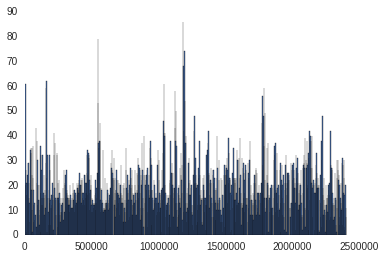

In [13]:
bins = np.linspace(0, st.max(), 1000)
plt.hist(st, bins);

## Probe

Here is how you can get the probe positions and make a plot:

In [14]:
channel_pos = model.probe.positions

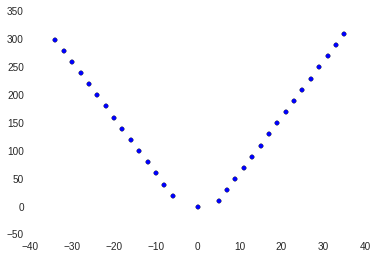

In [15]:
plt.scatter(channel_pos[:, 0], channel_pos[:, 1]);

## Clusters

To find out the list of clusters present in the file, you can use the `clustering` object:

In [16]:
clustering = session.clustering

Again, you can inspect the properties and methods of this object with tab completion. Here are the main properties:

In [17]:
clustering.n_clusters

24

Here is the list of clusters:

In [18]:
clustering.cluster_ids

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25], dtype=uint32)

> Note: cluster identifiers are unique. A given cluster as identified by its ID cannot change. If a merge happens, the old clusters are deleted and a new one is created. Idem for splits. This assumption makes the implementation much simpler.

Here are the number of spikes in the clusters:

In [19]:
clustering.cluster_counts

{2: 553,
 3: 188,
 4: 708,
 5: 260,
 6: 265,
 7: 667,
 8: 752,
 9: 1025,
 10: 6023,
 11: 402,
 12: 1740,
 13: 159,
 14: 487,
 15: 554,
 16: 731,
 17: 350,
 18: 550,
 19: 214,
 20: 354,
 21: 550,
 22: 404,
 23: 360,
 24: 825,
 25: 418}

Finally, the following variable is available for advanced uses: it is a dictionary mapping every cluster id to the list of spikes belonging to that cluster.

    clustering.spikes_per_cluster

## Visualization for manual sorting

Let's now move to the rich visualization widgets for manual clustering. There are three types of views currently implemented:

* **Feature view**
* **Waveform view**
* **Correlograms view**

Let's open a waveform view:

In [20]:
w = session.show_waveforms()

This should open a black window on your computer. It doesn't contain anything yet, because we have to select clusters first.

A **wizard** proposing pairs of candidate clusters for merging is still in the works. In the meantime, you can use Python to select interesting clusters. For example, let's look the biggest clusters:

In [21]:
# This sorts the dictionary by value (spike count) in decreasing order.
from operator import itemgetter
biggest = sorted(clustering.cluster_counts.items(), key=itemgetter(1))
biggest[-1:-6:-1]

[(10, 6023), (12, 1740), (9, 1025), (24, 825), (8, 752)]

The biggest cluster is the noise. Let's have a look at the next one:

In [22]:
session.select([12])

> You can pan and zoom with the mouse and the keyboard. The interaction patterns will be improved in the future.

Here is the feature view:

In [23]:
f = session.show_features()

The feature view displays the features of the selected clusters in several dimensions. The first dimension is time. The other are three channels that contain the highest number of unmasked spikes for these clusters.

There can be an arbitrary number of dimensions. There is no GUI yet to choose them, but in the meantime you can select dimensions manually like this:

In [24]:
# f.view.dimensions = ['time', (1, 0), (2, 0), (3, 0)]

This automatically updates the feature view. In this list, every item is a dimension represented by a column (or row, the grid is mostly symmetrical). The dimension can be either `'time'` or a tuple `(channel, feature)` where `feature` is typically 0, 1, or 2. On the diagonal, instead of seeing dimension `(channel, feature)` over the same dimension `(channel, feature)`, you see `(channel, feature)` over `(channel, feature_bis)` where `feature_bis = 1 - feature` (this will probably be improved in the future).

Finally, here are the correlograms (they are computed on the fly):

In [25]:
session.show_correlograms()

## Clustering

The `session` object implements some methods for clustering:

* `session.merge(clusters)`: this creates a new cluster out of the spikes contained in the specified clusters. The old clusters are deleted.
* `session.split(spikes)`: this create a new cluster out of the selected spikes. Since the old clusters are all modified as a result of this, their identifiers are all updated (they become new clusters with some spikes missing).
* `undo()` and `redo()`.

> See the next notebook example for a test of the clustering functionality.

## Features and waveforms

You can also access the features and waveforms data directly:

This is the `features_masks` array stored in the KWX file, memory-mapped by h5py:

In [26]:
model.features_masks

<HDF5 dataset "features_masks": shape (18539, 96, 2), type "<f4">

In [27]:
model.features.shape

(18539, 96)

You can use it as a normal NumPy array, but be careful because some access patterns are slow. If you want per-cluster data, you'd better use the cluster store (see later in this notebook.)

In [28]:
model.features[10:13, :5]

array([[  3.23068309,   6.34757376,   8.63135719,   1.46410561,
         -2.43757582],
       [  0.47218394,  -1.33231926,   1.6220597 ,  11.68298244,
         10.87937546],
       [ -3.53801465,  -5.62805319,   1.99024045,   0.91526592,
          4.60342264]], dtype=float32)

You can also access the waveforms. But note that these are not obtained from the KWX file: they are obtained directly from the raw data in the KWD file. This is because we'll remove the waveforms from the KWX file in the next version of the file format.

This looks like an array, but it's rather a proxy to the waveforms in the KWD file. Waveforms are filtered on-the-fly when they're loaded:

In [29]:
model.waveforms.shape

(18539, 32, 32)

This shows the waveforms of one spike:

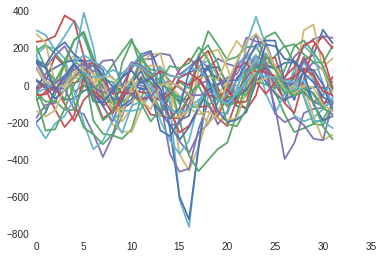

In [30]:
plt.plot(model.waveforms[100][0]);

> Of course, using the waveform view is a better idea in this case.

## Custom GUIs

We're still working on the GUI. In the meantime, with some knowledge of Python and IPython, you can build your own widgets.

For example, here is how you can create a little GUI to display the masks of a given cluster.

In [31]:
clusters = clustering.cluster_ids

In [32]:
from IPython.html.widgets import interact

:0: FutureWarning: IPython widgets are experimental and may change in the future.


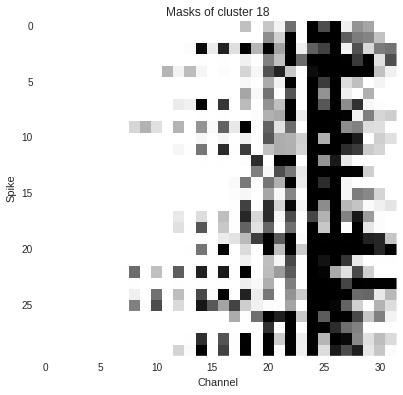

In [33]:
@interact(i=(0, len(clusters) - 1))
def show_masks(i=5):
    spikes = clustering.spikes_in_clusters([clusters[i]])
    plt.figure(figsize=(12,6))
    plt.imshow(model.masks[spikes[:30]], interpolation='none')
    plt.grid(None)
    plt.title("Masks of cluster %d" % clusters[i])
    plt.xlabel('Channel')
    plt.ylabel('Spike')

This displays a slider that allows you to go through all clusters and see their masks.

This will be mostly useful to Shabnam for the time being!

## Cluster store

The cluster store keeps per-cluster information. You can use it to retrieve some statistics related to the clusters.

In [34]:
store = session.cluster_store

For example, here is the average position of the spikes on the probe (in units of the channel position coordinates):

In [35]:
store.mean_probe_position(13)

array([ -1.42135382,  16.04123878], dtype=float32)

Average number of unmasked channels:

In [36]:
store.n_unmasked_channels(13)

24

The list of the main channels for that clusters:

In [37]:
store.main_channels(13)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       18, 19, 20, 21, 23, 24, 26])

> We planning to add many more statistics. You may also implement your own statistics directly in the notebook, and have them being updated automatically during the manual clustering session (API coming soon).

### Mini wizard

This cluster store will be the basis of the upcoming wizard. You can already implement in *one line of code* a very basic wizard by looking at clusters that are geometrically close to a given cluster:

In [38]:
target = 13
idx = np.argsort([np.dot(store.mean_masks(target), store.mean_masks(cluster)) for cluster in clusters])[::-1]
clusters[idx][:5]

array([ 6, 19,  2, 13, 16], dtype=uint32)

Cluster 1 is the noise. Cluster 1289 looks close to our cluster 1224: let's check that in the feature view.

In [39]:
session.select([16, 3])

The GUI will eventually implement something like this and offer quick keyboard shortcuts to look over pairs of similar clusters.

### Internal details on the cluster store

> Warning: internal details ahead.

phy keeps an internal cache of the features and masks in a subfolder of the original data folder. This takes some disk space, but it makes the interface vastly faster. Data belonging to a given custer is is a single file, which makes it very fast to load in RAM. Here is how it's organized if you're curious:

In [40]:
import os.path as op
exp_dir = op.dirname(filename)

In [41]:
%cd {exp_dir}

/home/cyrille/1_simple120sec


In [42]:
%ls

test_1.py.lprof*             test_hybrid_120sec.kwx*
test_hybrid_120sec.kwik*     test_hybrid_120sec.phy/
test_hybrid_120sec.kwik.bak  test_hybrid_120sec.raw.kwd*
test_hybrid_120sec.kwik~*


In [43]:
%cd test_hybrid_120sec.phy

/home/cyrille/1_simple120sec/test_hybrid_120sec.phy


In [44]:
%ls

cluster_store/  internal_settings


In [45]:
%cd cluster_store
%cd 0
%cd main

/home/cyrille/1_simple120sec/test_hybrid_120sec.phy/cluster_store
/home/cyrille/1_simple120sec/test_hybrid_120sec.phy/cluster_store/0
/home/cyrille/1_simple120sec/test_hybrid_120sec.phy/cluster_store/0/main


In [46]:
%ls

10.features  14.features  18.features  21.features  25.features  6.features
10.masks     14.masks     18.masks     21.masks     25.masks     6.masks
11.features  15.features  19.features  22.features  3.features   7.features
11.masks     15.masks     19.masks     22.masks     3.masks      7.masks
12.features  16.features  2.features   23.features  4.features   8.features
12.masks     16.masks     2.masks      23.masks     4.masks      8.masks
13.features  17.features  20.features  24.features  5.features   9.features
13.masks     17.masks     20.masks     24.masks     5.masks      9.masks


This is updated in real-time when doing merges and splits in the interface.

## Settings

You can put global settings in `~/.phy/user_settings.py`. Data-specific settings are to be in `/path/to/data/myexperiment.phy/user_settings.py`.

Here is an excerpt of the current default settings for manual clustering:

    # -----------------------------------------------------------------------------
    # Correlograms
    # -----------------------------------------------------------------------------

    # Number of time samples in a bin.
    manual_clustering.correlograms_binsize = 20

    # Number of bins (odd number).
    manual_clustering.correlograms_winsize_bins = 2 * 25 + 1

    # Maximum number of spikes for the correlograms.
    manual_clustering.correlograms_n_spikes_max = 1000000

    # Contiguous chunks of spikes for computing the CCGs.
    manual_clustering.correlograms_excerpt_size = 100000


    # -----------------------------------------------------------------------------
    # Views
    # -----------------------------------------------------------------------------

    # Maximum number of spikes to display in the waveform view.
    manual_clustering.waveforms_n_spikes_max = 100

    # Load contiguous chunks of waveforms (contiguous I/O is faster).
    # Higher value = faster loading of waveforms.
    manual_clustering.waveforms_excerpt_size = 20

    # Maximum number of spikes to display in the feature view.
    manual_clustering.features_n_spikes_max = 10000


## Conclusion

There are many more features to come, notably:

* Wizard
* Interactive cluster view
* GUI with the visualization widgets